In [2]:
import matplotlib.pyplot as plt
# plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8) # set default size of plots

В первом домашнем задании вам предлагается:

* Составить постановку задач машинного обучения языком математической статистики.
* Показать что $D_{KL}(p||q) \ge 0$ для любых $p$ и $q$. Для этого можно воспользоваться [формулой Йенсена](https://en.wikipedia.org/wiki/Jensen%27s_inequality "неравенство Йенсена")
* Показать, что максимизация правдопобия эквивалентна минимизации $D_{KL}$. 
* Найти непрерывное распределение (если среднее $\mu$ и дисперсия $\sigma^2$ заданы), для которого информационная энтропия максимальна. Подсказка: воспользуйтесь методом множителей Лагранжа.

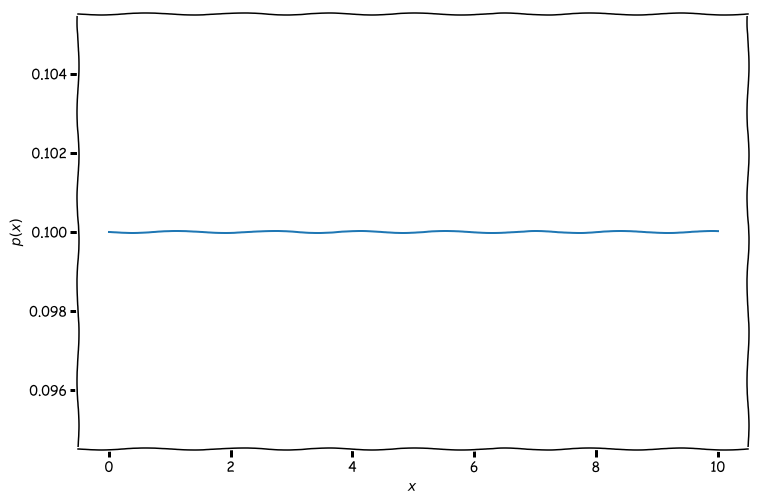

In [3]:
with plt.xkcd():
    plt.plot([0, 10], [0.1, 0.1])
    plt.ylabel('$p(x)$')
    plt.xlabel('$x$')

    plt.show()

* Для распределения, функция плотности которого изображена выше, найдите математическое ожидание и дисперсию.

$E(x) = \int_0^{10}x\cdot\frac{1}{10}\,\mathrm{d}x = \left.\left(\frac{x^2}{20}\right)\right|_0^{10}=5$

$V(x) = \int_0^{10}(x-5)^2\cdot\frac{1}{10}\,\mathrm{d}x = \int_{-5}^{5}t^2\cdot\frac{1}{10}\,\mathrm{d}t=
\left.\left(\frac{t^3}{30}\right)\right|_{-5}^{5}=\frac{25}{3}$

$\sigma=\frac{5}{\sqrt{3}}$

Формула Байеса:
$$ p(y|x) = \frac {p(x|y) p(y)} {p(x)}$$

* Решите задачу: Тест на лихорадку Эбола успешен в $95\%$ случаев. По статистике лихорадкой Эбола болеет один человек из ста. Если вы получили положительный результат теста, какова вероятность того, что вы действительно больны? 

Решения впишите на место этой ячейки. Для оформления можно (и нужно) воспользваоться [markdown](https://en.support.wordpress.com/markdown-quick-reference/) и формулами [TEX](https://en.wikibooks.org/wiki/LaTeX/Mathematics).

Буквально три-четыре года назад для того, чтобы обучить нейронную сеть было необходимо вручную вычислить градиент функции потерь. Затем, обычно, правильность решения проверялась численно. После появления фреймворков вроде Theano и TF это стало необязательным, благодаря чему исследователи и инженеры могут проводить свои эксперименты значительно быстрее. В данной работе мы посчитаем и проверим градиенты для линейных моделей, рассмотренных на первой лекции; а так же в явном виде реализуем алгоритм оптимизации.      

In [4]:
import numpy as np

In [5]:
from keras.datasets import cifar10
from random import randrange
import time

C:\Users\Public\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Для обучения мы будем использовать датасет CIFAR-10, состоящий из 60000 цветных изображений размера 32x32, разбитых на 10 классов, по 6000 изображений на класс. Обучающая выборка состоит из 50000 изображений, а тестовая -- из 10000. 

In [6]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [7]:
x_train.shape

(50000, 32, 32, 3)

Визуализируем классы

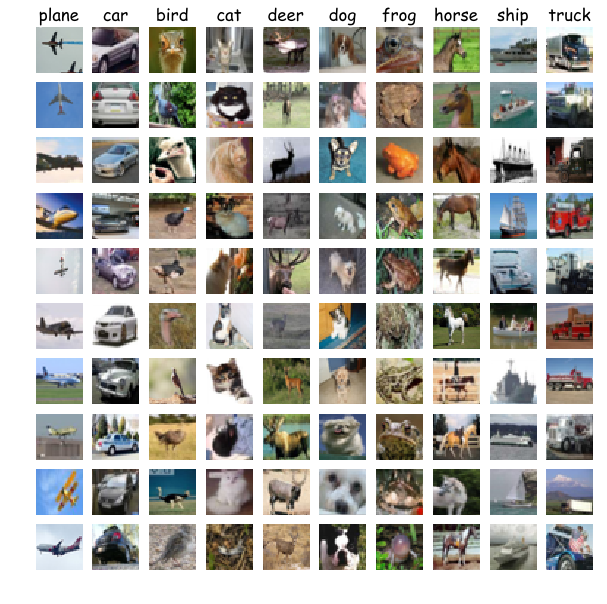

In [9]:
with plt.xkcd():
    classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    num_classes = len(classes)
    samples_per_class = 10
    plt.figure(figsize=(10,10))
    for y, cls in enumerate(classes):
        idxs = np.flatnonzero(y_train == y)
        idxs = np.random.choice(idxs, samples_per_class, replace=False)
        for i, idx in enumerate(idxs):
            plt_idx = i * num_classes + y + 1
            plt.subplot(samples_per_class, num_classes, plt_idx)
            plt.imshow(x_train[idx].astype('uint8'))
            plt.axis('off')
            if i == 0:
                plt.title(cls)
    plt.show()

In [10]:
# Preprocessing: преобразуем изображения к плоскому виду
x_train = np.reshape(x_train, (x_train.shape[0], -1))
x_test = np.reshape(x_test, (x_test.shape[0], -1))

# Печатаем размерности, чтобы проверить что мы не ошиблись
print('Training data shape: ', x_train.shape)
print('Test data shape: ', x_test.shape)

Training data shape:  (50000, 3072)
Test data shape:  (10000, 3072)


[130.71074 136.05614 132.5538  130.14036 135.44238 131.85358 131.05044
 136.24616 132.58144 131.56886]


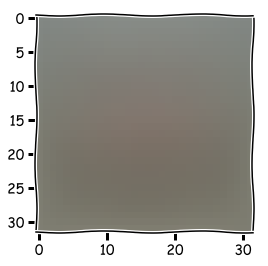

In [11]:
# Preprocessing: вычитаем среднее
# 1: Находим среднее изображение
mean_image = np.mean(x_train, axis=0)
print(mean_image[:10]) # для проверки напечаем несколько элементов
with plt.xkcd():
    plt.figure(figsize=(4,4))
    plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # визуализируем полученное среднее
    plt.show()

In [12]:
# 2: вычитаем среднее из изображений обучающей и тестовых выборок
x_train = x_train - mean_image
x_test = x_test - mean_image

In [13]:
print(x_train.shape)

(50000, 3072)


In [14]:
# 3: Добавляем новую компоненту отвечающую за сдвиг (bias trick)
x_train = np.hstack([x_train, np.ones((x_train.shape[0], 1))])
x_test = np.hstack([x_test, np.ones((x_test.shape[0], 1))])

In [15]:
print(x_train.shape)

(50000, 3073)


**Задача 1:** Далее следует [функция потерь SVM (hinge loss)](https://en.wikipedia.org/wiki/Hinge_loss), которую вам предстоит дописать.

In [597]:
import time

def svm_loss(W, X, y, reg, verbose = False):
    """
    SVM loss function
    Inputs:
    - W: Матрица весов  ## num_classes x num_pixels
    - X: Данные        ###  num_obs x num_pixels
    - y: Целевой признак 
    - reg: (float) Коэффициент регуляризации
    Returns:
    a tuple:
    - loss (одно число)
    - градиент по W
    """
    

    # Впишите свой код на место заглушки
    loss = 0
    dW = np.zeros(W.shape)
    dW1 = np.zeros(W.shape)

    num_class = W.shape[0]
    num_obs = X.shape[0]
    num_vars = X.shape[1]
    
    delta = 1
    eps = 1e-10
    
    st = time.time()
    ## loss function
    dt_score = np.dot(X,np.transpose(W))
    score_true = dt_score[np.arange(0,num_obs),np.reshape(y,-1)]
    score_true = np.reshape(score_true,(-1,1))
    dt_loss = dt_score - score_true + delta
    dt_loss[np.arange(0,num_obs),np.reshape(y,-1)] = 0
    dt_loss[dt_loss<0] = 0
    loss = np.sum(dt_loss) ## + reg * np.sum(W*W)
    
    dt_loss[dt_loss>eps]=1
    
    if verbose: print (time.time()-st)
    st = time.time()
    
    ## Calculate dW
    ##
    dW = np.dot(np.transpose(X), dt_loss)
    dW = np.transpose(dW)
    if verbose: print (dW)
    
     
    ## number of mismatches
    num_incorrect = np.sum(dt_loss>0,axis=1)
    aa = np.zeros((num_obs,num_class))
    aa[np.arange(0,num_obs),np.reshape(y,-1)] = num_incorrect
    if verbose: print (aa)
    
    aa = np.dot(np.transpose(X),aa)
    if verbose: print (aa)
    if verbose: print (aa.shape)
        
    dW = dW - np.transpose(aa)

#     if verbose: print (time.time()-st)
#     st = time.time()
    
#     for i_class in range(num_class):
# #         aa = X[dt_loss[:,i_class]>eps,:]
# #         aa = np.sum(aa,axis=0)
# #         dW1[i_class,:] = aa
        
# #         ## gradient for correct class
#         try:
#             num_incorrect = np.sum(dt_loss[np.reshape(y,-1)==i_class,:]>eps,axis=1)
#             num_incorrect = np.reshape(num_incorrect,(-1,1))
#             aa = -np.sum(X[np.reshape(y,-1)==i_class,:] * num_incorrect,axis=0)
#         except:
#             aa = np.zeros(num_vars)
            
#         dW[i_class,:] += aa
    
#     print (dW1)
    if verbose: print (time.time()-st)
    st = time.time()

    return loss, dW

In [598]:
# Заполняем матрицу весов W случайным образом
W = np.random.randn(10, 3073) * 0.0001 


loss, grad = svm_loss(W, x_test, y_test, 0.000005, verbose = True)
print('loss: %f' % (loss, ))

0.09726071357727051
[[ -9567.85902 -17713.32322 -35896.1774  ... -10409.1969  -18649.15078
    8823.     ]
 [  2973.87608  11509.13288  13419.5096  ...  14170.5876   13441.76312
    8708.     ]
 [  6759.51282   8031.57502  22829.6834  ...   3013.4079   17775.95898
    8807.     ]
 ...
 [  1645.00018   3914.16798   6420.1266  ...  -2712.1729   18647.39802
    8743.     ]
 [  3495.8675   -2132.2075  -17908.525   ...  21022.1625    8513.4575
    8625.     ]
 [-43143.7602  -46451.1022  -57097.674   ... -20326.119   -19352.6378
    8730.     ]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 8. 0.]
 [0. 0. 0. ... 0. 9. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 9. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 9. 0. 0.]]
[[ 137056.75244   29189.61164  -67753.63564 ...   47709.84314
   102927.5692   287839.28132]
 [ 240580.30484  -13423.20396  -48701.86004 ...   61335.39254
   198907.3012   331975.97852]
 [ 426819.8828     -544.8132  -155525.0668  ...   74998.3418
   369588.004    433137.5284 ]
 ...
 [ 127700.4618 

In [599]:
#При помощи этой функции можно проверить градиент численно 
def grad_check_sparse(f, x, analytic_grad, num_checks):
    """
    sample a few random elements and only return numerical
    in this dimensions.
    """
    h = 1e-8

    for i in range(num_checks):
        ix = tuple([randrange(m) for m in x.shape])

        x[ix] += h # increment by h
        fxph = f(x) # evaluate f(x + h)
        x[ix] -= 2 * h # increment by h
        fxmh = f(x) # evaluate f(x - h)
        x[ix] += h # reset

        grad_numerical = (fxph - fxmh) / (2 * h)
        grad_analytic = analytic_grad[ix]
        rel_error = abs(grad_numerical - grad_analytic) / (abs(grad_numerical) + abs(grad_analytic))
        print ('numerical: %f analytic: %f, relative error: %e' % (grad_numerical, grad_analytic, rel_error))

In [600]:
# Вычисляем значение функции потерь и её градиент для W.
loss, grad = svm_loss(W, x_test, y_test, 0.0)

# Проверяем численно
# f = lambda w: svm_loss(w, x_test, y_test, 0.0)[0]
# grad_numerical = grad_check_sparse(f, W, grad, 10)

print ("\nGradient with regularization")
# Проверяем численно, используя регуляризацию.
# Вы ведь не забыли реализовать регуляризацию, правда? 
loss, grad = svm_loss(W, x_test, y_test, 5e1)
f = lambda w: svm_loss(w, x_test, y_test, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)


Gradient with regularization
numerical: 44056.285697 analytic: 44056.286400, relative error: 7.983312e-09
numerical: 224487.657397 analytic: 224487.657920, relative error: 1.165273e-09
numerical: -11702.903430 analytic: -11702.903360, relative error: 2.989751e-09
numerical: 1263.702870 analytic: 1263.703360, relative error: 1.937375e-07
numerical: -1614.743087 analytic: -1614.742900, relative error: 5.789623e-08
numerical: 21174.734866 analytic: 21174.735200, relative error: 7.891931e-09
numerical: -246134.571353 analytic: -246134.571100, relative error: 5.134198e-10
numerical: 18850.868219 analytic: 18850.868160, relative error: 1.553734e-09
numerical: 174540.720036 analytic: 174540.720800, relative error: 2.188543e-09
numerical: -107556.761941 analytic: -107556.761520, relative error: 1.956832e-09


**Задача 2:** Реализуйте методы класса SVM. Для тренировки используйте градиентный спуск.

In [20]:
class SVM():
    def __init__(self):
        self.W = np.random.randn(10, 3073) * 0.0001 
        
    def train(self, x_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1000, verbose=True):
        #Здесь (на месте заглушки) впишите релаизацию градиентного спуска, используя функцию потерь, которую вы определелили выше.
        #Если обучение проходит слишком медленно, возможно необходимо что-то улучшить?
        loss_history = []
        for it in range(num_iters):
            loss = 0
            loss_history.append(loss)

        return loss_history
    def predict(self, y):
        pass

Проверяем полученную реализацию.

In [23]:
tic = time.time()
svm = SVM()
loss_hist = svm.train(x_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

That took 0.001257s


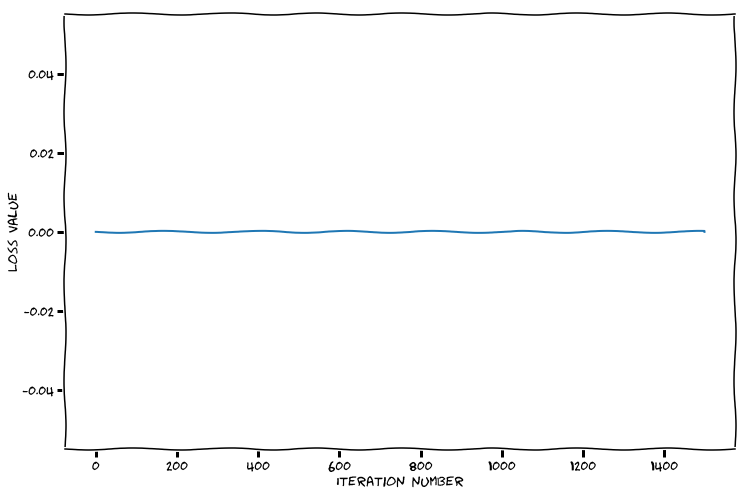

In [24]:
# Хорошая идея для отладки -- нарисовать график отношения функци потерь к номеру итерации 
with plt.xkcd():
    plt.plot(loss_hist)
    plt.xlabel('Iteration number')
    plt.ylabel('Loss value')
    plt.show()

In [27]:
# Теперь вычислим точность на тренировочном и тестовом множествах
y_train_pred = svm.predict(x_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_test_pred = svm.predict(x_test)
print('validation accuracy: %f' % (np.mean(y_test == y_test_pred), ))

training accuracy: 0.000000
validation accuracy: 0.000000


In [28]:
def plot_weights(best_svm):
    with plt.xkcd():
        w = best_svm.W[:,:-1] # strip out the bias
        w = w.reshape(10, 32, 32, 3)
        w_min, w_max = np.min(w), np.max(w)
        classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
        for i in range(10):
            plt.subplot(2, 5, i + 1)

            # Rescale the weights to be between 0 and 255
            wimg = 255.0 * (w[i, :, :, :].squeeze() - w_min) / (w_max - w_min)
            plt.imshow(wimg.astype('uint8'))
            plt.axis('off')
            plt.title(classes[i])

**Задача 3:** Подберите при помощи поиска по сетке наулучшие параметры learning rate и regularization coefficient. Для полученной модели вызовите функцию plot_weights(best_svm). Впишите свой код под этой ячейкой.

**Задача 4:** О чём говорят полученные изображения? Какие выводы мы можем сделать? Впишите ответ в поле ниже

**Задача 5:** Повторим упражнение для [cross entropy loss](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_error_function_and_logistic_regression)

In [29]:
def crossentropy_loss(W, X, y, reg):
    """
    Cross entropy loss function
   Inputs:
    - W: Матрица весов
    - X: Данные
    - y: Целевой признак
    - reg: (float) Коэффициент регуляризации
    Returns:
    a tuple:
    - loss (одно число)
    - градиент по W
    """
    
    # Впишите свой код на место заглушки
    loss = 0
    dW = np.zeros(W.shape)

    return loss, dW

In [30]:
# Вычисляем значение функции потерь и её градиент для W.
loss, grad = crossentropy_loss(W, x_test, y_test, 0.0)

In [33]:
# Грубая проверка, значения должны быть близки к -log(0.1).
print (f'loss: {loss}')
print (f'sanity check: {(-np.log(0.1))}')

loss: 0
sanity check: 2.3025850929940455


**Задача 6:** Кстати, почему такая проверка справедлива? Объясните

In [34]:
f = lambda w: crossentropy_loss(w, x_test, y_test, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)


loss, grad = crossentropy_loss(W, x_test, y_test, 5e1)
f = lambda w: crossentropy_loss(w, x_test, y_test, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: 0.000000 analytic: 0.000000, 

/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
